# Time serial anomaly detection with LSTM

In [1]:
# Author: Victora Zhang, SOA
# Use LSTM to perform anomly detection

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing

Anomaly detection is critial in the time serial data sepecially for the financal industry. It could help us remove the outliers from the data. Anomaly detection has a wide range of applications such as fraud detection, health monitoring, web traffic monitoring and so on. Anomly detection in the time serial data can also help us identity the signals before some events happens. In this section, we are going to use the Numenta Anomaly Benchmark (NAB) dataset to demonstrate that the LSTM can aslo be used to detect the anonaly in the time serials data. 

## Why LSTM?


In theory a classifier can also be used for anomly detection as long as we have labels for each time points to know whether current time point is an outlier or not. However, labeling every time point in partice is very costly. Moreover, ususally the number of anomalies is typically way less than the regular data, therefore it is highly unbalanced. Training a machine learning based classifier with unbalanced labels is very diffcult as the model might be overfitted with the one with more labels. 
RNN or LSTM is a naturaly fit for time serial anomly detection. We are trying to train a LSTM model so it can predict the future data. If we see a hugh difference beween our prediction and the incoming data, then we would suspect current data might be an outlier.

## Dataset

The Numenta Anomaly Benchmark: https://github.com/numenta/NAB
Numenta Anomaly Benchmark (NAB), is a novel benchmark for evaluating algorithms for anomaly detection in streaming, real-time applications. It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications. We select the NYC taxi data from this dataset. It includes the number of taxi passengers between July 01, 2014 and Jan 31, 2015 and it consists of aggregating the total number of taxi passengers into 30 minute buckets. In this NYC taxi data, there are five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. We will build a LSTM model trying to detect those anomalies.

## Data Preparation

As we have discussed previously, the first thing to train a machine learning model is to normalize the data so that the data is with zero mean and normalized the scale. 
The model we used is pretty much the same with the one used in Nasdaq index prediction, the difference is we only have passengers numbers of previous time points and try to predict the number of next 30 mins. 
Here, we are also using a rolling windown approach and will use the last N time points to predict the next time point. N is a tunable hyper-parameter and is set to be 50 during the training. Mathmatically, we are trying to find a mappinf function f, which will map current LSTM state h_t and past N data to predict X_t+1.

x_t+1 = f(h_t, x_t-N,...x_t). 

The while data is split into two pars, the first 70% data will be used for training and the remaining 30% will be used as testing data to evalulate the mode. 

In [2]:
# Load the data
df = pd.read_csv('../data/NAB/realKnownCause/nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['number_of_passengers'] = df['value']

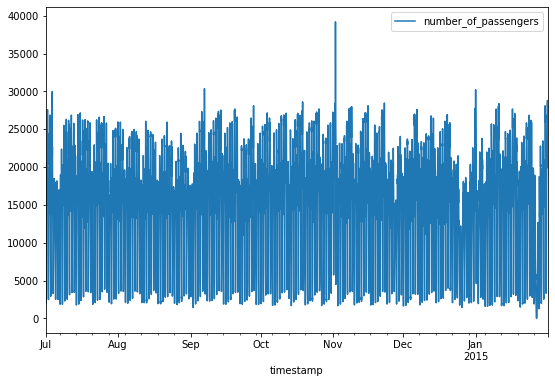

In [3]:
# Data Visualization
plot = df.plot(x='timestamp', y='number_of_passengers', figsize = (9, 6))
fig = plot.get_figure()
fig.savefig("nyc_taxi_data_raw.png")

In [4]:
# Normalize the number of passengers
data_n = df[['value']]
min_max_scaler = preprocessing.StandardScaler()
data_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(data_scaled)

In [44]:
# important parameters and train/test size
prediction_time = 1 
testdatasize = 4000
time_window_length = 100
testdatacut = testdatasize + time_window_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [45]:
#Convert the time serial data into the supervise learning data
def to_supervise(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = to_supervise(x_train,time_window_length)
x_test  = to_supervise(x_test,time_window_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6118, 100, 1)
y_train (6118,)
x_test (4000, 100, 1)
y_test (4000,)


In [7]:
# Import LSTM layers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential


Using TensorFlow backend.


In [8]:
# Build the model
def build_model():
    model = Sequential()

    model.add(LSTM(
        input_dim=x_train.shape[-1],
        output_dim=50,
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=1))
    model.add(Activation('linear'))

    model.compile(loss='mse', optimizer='rmsprop')
    return model

In [9]:
def train_model(model, batch_size = 256, num_epoches = 25, validation_split = 0.3):
    model.fit(
        x_train,
        y_train,
        batch_size = batch_size,
        epochs = num_epoches,
        validation_split = validation_split)

In [ ]:
# Build and train the model
model = build_model()
train_model(model)

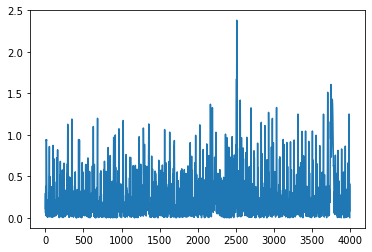

In [46]:
# Compute the difference between the original data the the prediction
def compute_predit_error(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_err = np.abs(y_pred.ravel() - y_test.ravel())
    return y_err, y_pred

diff, y_pred = compute_predit_error(model, x_test, y_test)
plt.plot(diff)

## Anomly detection with trained model

We train the model with 25 epoches and stop the training once the error between the prediction and training data are small enough. 
We first use the trained model to predict the future taxi passenger numbers and visualize the prediction results as below. From the plot, the prediction looks pretty close to the test data, which proves that the model fits both the training and test data quite well. 


4000

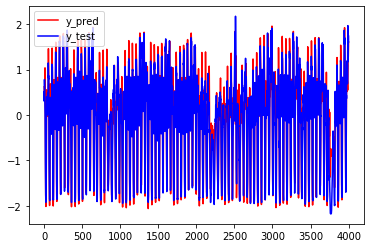

In [48]:
# Prediction vs Goundtruth
fig, axs = plt.subplots()
axs.plot(y_pred, color='red', label='y_pred')
axs.plot(y_test, color='blue', label='y_test')
plt.legend(loc='upper left')
fig.savefig("test_vs_predict.png")
diff.shape[0]

Next, we are going to detect the outliers from the test data. We define that there are about 0.5% of outliers. We will compute the error between prediction and original test data, and the top 0.5% with largest error will be the suspicious outliers. It is interesting to see that we correctly detect the outliers around Xmas and New year day and also the snow storms (2015-01-23 to 2015-01-30) but failed to detect the NYC marathon (2014-11-02) and Thanksgiving (2014-11-27).
There are some improvements we can do to improve the model performance but the results are good enough to show that we could use LSTM to succesfully detect most of anomlies within out data.

In [49]:
outlier_ratio = 0.005
diff = pd.Series(diff)
num_outliers = int(outlier_ratio * diff.shape[0])
threshold = diff.nlargest(num_outliers).min()

anomaly = (diff >= threshold).astype(bool)

complement = pd.Series(False, index=np.arange(len(data_n)-testdatasize))

df['is_anomaly'] = complement.append(anomaly, ignore_index='True')
df_anomaly = df.loc[df['is_anomaly'] == 1, ['timestamp', 'value']]

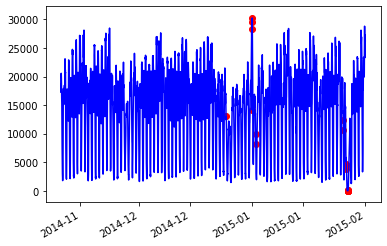

In [53]:
fig, ax = plt.subplots()
ax.plot(df['timestamp'].iloc[-testdatasize:], df['value'].iloc[-testdatasize:], color='blue')
ax.scatter(df_anomaly['timestamp'], df_anomaly['value'], color='red')
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

fig.savefig("outliers.png", figsize=(8, 6))

In [52]:
df_anomaly

,timestamp,value
8488,2014-12-24 20:00:00,13101
8831,2014-12-31 23:30:00,14152
8833,2015-01-01 00:30:00,29547
8834,2015-01-01 01:00:00,30236
8835,2015-01-01 01:30:00,28348
8879,2015-01-01 23:30:00,9947
8880,2015-01-02 00:00:00,8258
10028,2015-01-25 22:00:00,12374
10029,2015-01-25 22:30:00,10625
10070,2015-01-26 19:00:00,4729
